# Import libraries

In [2]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB2,EfficientNetB3,EfficientNetB5,InceptionResNetV2#,EfficientNetV2S
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import keras
import sklearn.metrics as metrics
from sklearn.metrics import classification_report
#from pretty_confusion_matrix import pp_matrix
#confusion_matrix = metrics.confusion_matrix(y_true=y_test_labels, y_pred=pred_labels)  # shape=(12, 12)
from sklearn.metrics import confusion_matrix

In [3]:
#!pip install tf-nightly
#!pip install keras_efficientnets
#!pip install pretty-confusion-matrix

# Create labels 

In [4]:
#create labels
classes=[]
filename='../input/brain-tumor-classification-mri'
for sub_folder in os.listdir(os.path.join(filename,'Training')):
    classes.append(sub_folder)
print(classes)


['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']


# Resize images and put together Training and Testing folder 

In [5]:
#resize images and put together Training and Testing folder

X_train = []
y_train = []
image_size = 160
for i in classes:
    path_train = os.path.join(filename,'Training',i)
    for j in tqdm(os.listdir(path_train)): #Instantly make your loops show a smart progress meter 
        img = cv2.imread(os.path.join(path_train,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
    path_test = os.path.join(filename,'Testing',i)
    for j in tqdm(os.listdir(path_test)):
        img = cv2.imread(os.path.join(path_test,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)    

100%|██████████| 100/100 [00:00<00:00, 128.28it/s]


# Data splitting

In [6]:
#data augmentation
X_train, y_train = shuffle(X_train,y_train, random_state=42)
datagen = ImageDataGenerator(
    rotation_range=7, #rotate images
    width_shift_range=0.05,
    height_shift_range=0.05, #shift image in horizontal and vertical
    zoom_range=0.1, #zoom images
    horizontal_flip=True)

datagen.fit(X_train)
X_train.shape
lb = LabelEncoder()

#train and test splitting 
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.15,random_state=42,stratify=y_train)

labels_train=lb.fit(y_train)
y_train=lb.transform(y_train)
y_test=lb.transform(y_test)

In [7]:
X_test

array([[[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        ...,

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]],

        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0]]],


       [[[16, 16, 16],
         [13, 13, 13],
         [18, 

## <font color='Aquamarine'>Load EfficientNetB3</font> 

In [8]:
print(y_train)

#load EfficientNet
EfficientNet=EfficientNetB3(weights='imagenet', include_top=False,input_shape=(image_size,image_size,3))

[3 1 1 ... 3 3 0]


2022-11-17 13:10:56.875329: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


43950080/43941136 [==============================] - 2s 0us/step


## <font color='Aquamarine'>Train the model</font> 

In [9]:
#train the model
tf.random.set_seed(45)
model = EfficientNet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.55)(model)
model = tf.keras.layers.Dense(60,activation='elu',kernel_initializer='GlorotNormal')(model)
model = tf.keras.layers.Dropout(rate=0.3)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=EfficientNet.input, outputs = model)
opt = Adam(
    learning_rate=0.000016, beta_1=0.91, beta_2=0.9994,
    epsilon=1e-08)

model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

# summarize the model
print(model.summary())
# fit the model
early_stopping_cb=keras.callbacks.EarlyStopping(patience=9,restore_best_weights=True)


history=model.fit(X_train ,y_train,validation_data = (X_test,y_test),epochs=15,
    batch_size=30,callbacks=early_stopping_cb)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 160, 160, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 160, 160, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 161, 161, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

2022-11-17 13:11:01.982113: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
93/93 [==============================] - 254s 3s/step - loss: 1.4236 - accuracy: 0.3702 - val_loss: 1.3097 - val_accuracy: 0.3633
Epoch 2/15
93/93 [==============================] - 237s 3s/step - loss: 1.0614 - accuracy: 0.5609 - val_loss: 1.1239 - val_accuracy: 0.5245
Epoch 3/15
93/93 [==============================] - 228s 2s/step - loss: 0.8553 - accuracy: 0.6629 - val_loss: 1.0391 - val_accuracy: 0.6020
Epoch 4/15
93/93 [==============================] - 247s 3s/step - loss: 0.6977 - accuracy: 0.7318 - val_loss: 0.9351 - val_accuracy: 0.6388
Epoch 5/15
93/93 [==============================] - 252s 3s/step - loss: 0.6074 - accuracy: 0.7747 - val_loss: 0.8519 - val_accuracy: 0.6898
Epoch 6/15
93/93 [==============================] - 252s 3s/step - loss: 0.5417 - accuracy: 0.7999 - val_loss: 0.7348 - val_accuracy: 0.7327
Epoch 7/15
93/93 [==============================] - 252s 3s/step - loss: 0.4668 - accuracy: 0.8367 - val_loss: 0.6042 - val_accuracy: 0.7816
Epoch 8/15
93

In [14]:
y_train.shape,y_test.shape

((2774,), (490,))

In [15]:
model.save('test_model_2.h5')

In [17]:
Predict = model.predict(X_test)

## Evaluation

16/16 [==============================] - 10s 595ms/step - loss: 0.2444 - accuracy: 0.9245
Accuracy: 92.448980


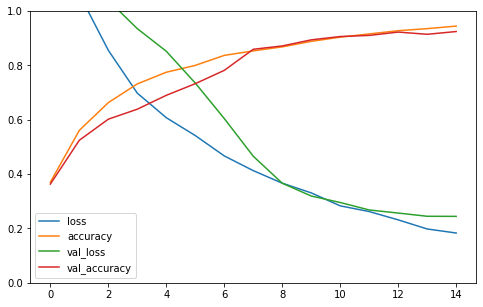

In [18]:

#plot loss and accuracy
pd.DataFrame(history.history).plot(figsize=(8, 5))
#plt.grid(True)

#plt.gca().set_xlim(0,33)
plt.gca().set_ylim(0,1)
plt.savefig('/kaggle/working/EfficientNetB3.png')
loss, accuracy = model.evaluate(X_test,y_test)

#print accuracy    
print('Accuracy: %f' % (accuracy*100))

In [19]:
#model.summary()
loss, accuracy = model.evaluate(X_test,y_test)


16/16 [==============================] - 10s 604ms/step - loss: 0.2444 - accuracy: 0.9245


## Accuracy and Loss

In [21]:
print(f'accuracy : {round(accuracy*100,3)} \n loss : {round(loss,3)}')

accuracy : 92.449 
 loss : 0.244


In [22]:

y_test_labels=lb.inverse_transform(y_test)

#predicted values
pred=np.argmax(model.predict(X_test),axis=1)
pred_labels=lb.inverse_transform(pred) #predicted labels

In [23]:
pd.Series(pred_labels).value_counts()

meningioma_tumor    152
pituitary_tumor     138
glioma_tumor        120
no_tumor             80
dtype: int64

In [40]:
import pandas as pd

In [44]:
y_pred = model.predict(X_test)
y_pred_array = np.argmax(y_pred, axis = 1) 
x={"y_test":y_test, "y_pred": y_pred_array}

df4 = pd.DataFrame(x)
df4.head(10)

,y_test,y_pred
0,0,0
1,2,2
2,1,1
3,3,3
4,0,1
5,1,1
6,3,3
7,0,1
8,2,2
9,1,1


## Confusion Matrix 

Text(70.8, 0.5, 'Predicted class')

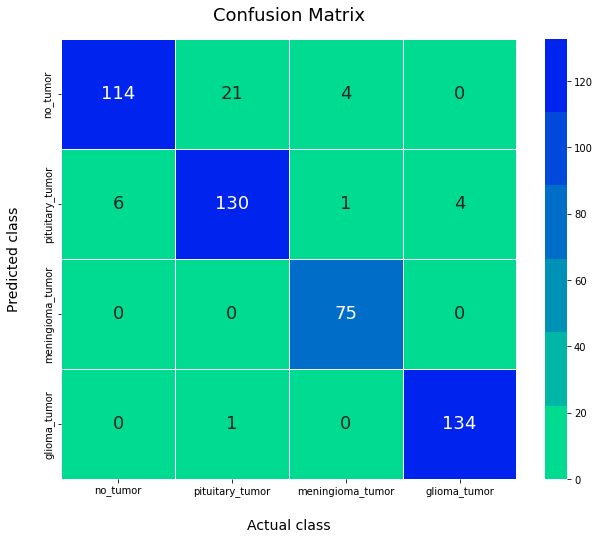

In [24]:
cm = confusion_matrix(y_test,pred)
fig,ax= plt.subplots(figsize=(10.2,8.1))
a=sns.color_palette("winter_r")  #_r inverts the palette
sns.heatmap(cm, annot=True,fmt='g',linewidths=1,linecolor='white',robust=True,annot_kws={"size":18},cmap=a)
 #annot_kws: settings about annotations
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.yticks(va="center")
plt.title('Confusion Matrix',fontsize=18,pad=18)
plt.xlabel('Actual class',labelpad=22,fontsize=14)
plt.ylabel('Predicted class',labelpad=22,fontsize=14)
#plt.savefig(os.path.join('plots/','EfficientNetB3_confusion_matrix.png'), dpi=300)

## <font color='Aquamarine'>Model performance scores</font> 

In [25]:
print(classification_report(y_test,pred,target_names=classes))

                  precision    recall  f1-score   support

        no_tumor       0.95      0.82      0.88       139
 pituitary_tumor       0.86      0.92      0.89       141
meningioma_tumor       0.94      1.00      0.97        75
    glioma_tumor       0.97      0.99      0.98       135

        accuracy                           0.92       490
       macro avg       0.93      0.93      0.93       490
    weighted avg       0.93      0.92      0.92       490

